In [1]:
import pandas as pd
import numpy as np
import seaborn as sb
import matplotlib.pyplot as plt
import sklearn as skl
from hmmlearn import hmm

%matplotlib inline
np.random.seed(5678)

# Taipei, Taiwan Air Pollution
Data set from [kaggle](https://www.kaggle.com/nelsonchu/air-quality-in-northern-taiwan) looking at varying metrics of air polution as well as simplified weather information.  Data is well documented with explanations as to validity and sampling error.  

In this notebook, a series of markov models will be fitted to the above data in hopes of modeling polution levels as a function of wind direction.  

## Importing and Cleaning Data
Data was imported in `.csv` format. We removed datapoints marked as invalid and forward filled to maintain continuity. 


In [2]:
# initial data cleaning
# file_path = "data/2015_Air_quality_in_northern_Taiwan.csv"
# df = pd.read_csv(file_path, parse_dates=["time"],index_col="time")
# df.iloc[:,1:] = df.iloc[:,1:].apply(lambda x: pd.to_numeric(x,errors='coerce'),axis=1).copy()
# df.to_csv("data/2015_removed_marked_data.csv", index=False)

# final data used
file_path = "data/2015_removed_marked_data.csv"
taipai = pd.read_csv(file_path)
taipai = taipai.fillna(method='ffill')
taipai.head()

,station,AMB_TEMP,CH4,CO,NMHC,NO,NO2,NOx,O3,PH_RAIN,...,RAINFALL,RAIN_COND,RH,SO2,THC,UVB,WD_HR,WIND_DIREC,WIND_SPEED,WS_HR
0,Banqiao,16.0,2.1,0.79,0.14,1.2,16.0,17.0,37.0,NaN,...,NaN,NaN,57.0,12.0,2.2,0.0,69.0,69.0,4.7,4.2
1,Banqiao,16.0,2.1,0.80,0.15,1.3,16.0,17.0,36.0,NaN,...,NaN,NaN,57.0,11.0,2.2,0.0,67.0,65.0,4.0,4.0
2,Banqiao,16.0,2.1,0.71,0.13,1.0,13.0,14.0,38.0,NaN,...,NaN,NaN,57.0,8.0,2.2,0.0,63.0,53.0,3.7,3.5
3,Banqiao,15.0,2.0,0.66,0.12,0.8,11.0,12.0,39.0,NaN,...,NaN,NaN,58.0,6.5,2.2,0.0,63.0,63.0,4.1,3.3
4,Banqiao,15.0,2.0,0.53,0.11,0.6,10.0,11.0,38.0,NaN,...,NaN,NaN,58.0,5.5,2.1,0.0,69.0,67.0,3.0,3.1


## Selection of 5 Interesting Particulates 

NO, NO2, and NOx are Nitrogen Oxygen based emissions originating from vehicle exaust. 

SO2 is a sulfer based molecule that agitates the skin, eyes, and nose.

O3 or Ozone at low altitude is generated by the combination of NOx, other organic compounds and sunlight.

For now we are selecting a single station, but the other stations will be included in the modeling step.

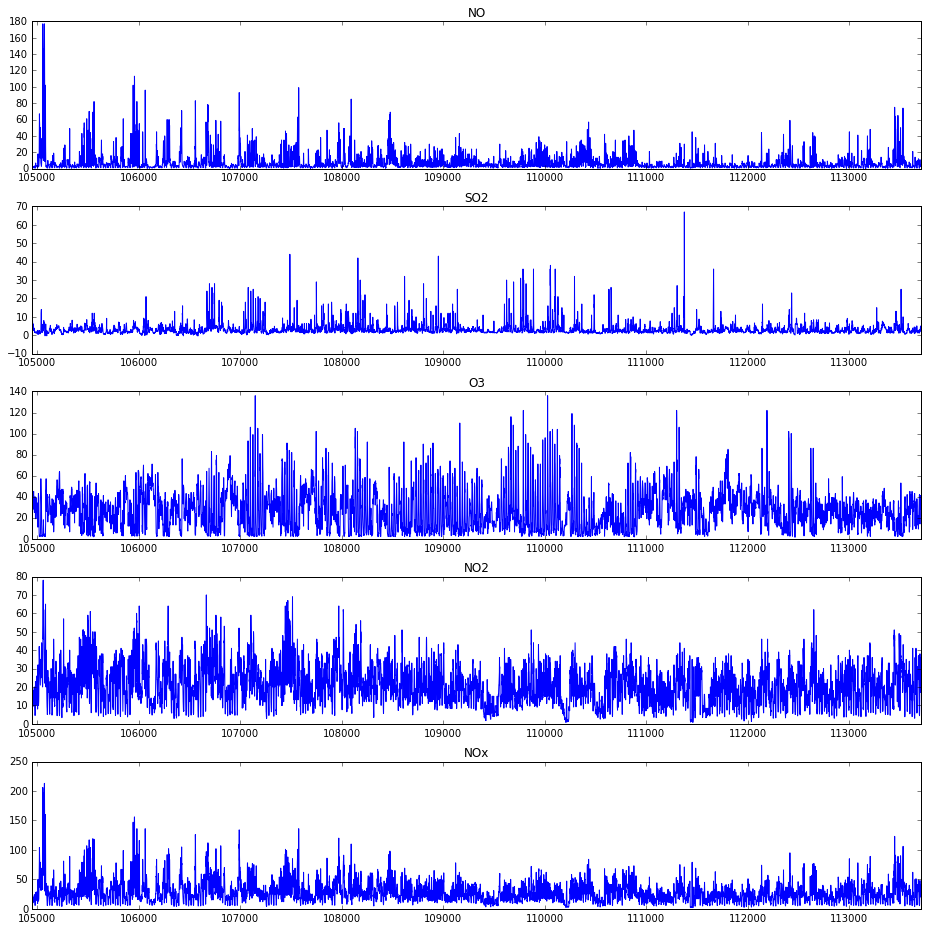

In [3]:
fig, axes = plt.subplots(nrows=5, ncols=1, figsize=(13,13))
for (pol, ax) in zip(["NO","SO2","O3","NO2","NOx"], axes):
    taipai[pol].loc[taipai.station == "Songshan"].plot(ax=ax)
    ax.set_title(pol)
fig.tight_layout()

# Creation of Markov Models
We hypothesized that pollution in a city might be modeled as a markov chain. If pollutants are continuously being produced from point sources, then the direction of the wind will determine what pollutants make it to the sensor. In that regard, the pollutant reading are the observations of a the wind direction state.

Since pollutant levels are continuous, and not discrete, we'll develope a gaussian mixed models markov chain. This will be done using `hmmlearn` and computing the statistics for the model directly from the data.

Below are all the important functions used in this process:

In [4]:
def bin_winds(col,n):
    """
    Gins the ginds in the gol into g gins 
    """
    cuts = np.linspace(0, 360, n + 1)
    col_binned = pd.cut(col, bins = cuts, labels = False)
    return col_binned


def compute_wind_trans(bin_col):
    """
    Computes the transition matrix for the winds states; necessary for the MM
    
    Arguments
    ---------
    bin_col -- binned wind column; id as 0 indexed integers
    """
    # matrix of state transitions
    n = len(bin_col.unique())
    transition = np.ones((n,n)) 
    for i, j in zip(bin_col[:-1], bin_col[1:]):
        transition[int(i), int(j)] += 1

    # row normalize transition matrix
    row_sum = transition.sum(axis=1)

    return transition / row_sum[:, np.newaxis]


def compute_state_means(df, bin_col):
    """
    Compute an array of state means for each of the states; return a matrix of n states by m obserables
    """
    n, m = len(df[bin_col].unique()), df.shape[1] - 1
    mean_matrix = np.zeros((n,m))
    
    for s in np.sort(df[bin_col].unique()):
        mean_matrix[int(s),:] = df.loc[df[bin_col] == s, df.columns != bin_col].mean(axis=0)
        
    return mean_matrix


def split_train_test(df, p_train):
    """
    Splits our df into train test...scikit probably has this
    """
    i_test = int(df.shape[0] * p_train)
    train, test = df.iloc[:i_test,:], df.iloc[i_test:,:]
    return train, test


def compute_covar(df, bin_col):
    """
    Compute covariance matrices for each time
    """
    n, m = len(df[bin_col].unique()), df.shape[1] - 1
    cov_mat = np.zeros((n, m))
    
    for s in np.sort(df[bin_col].unique()):
        cov_mat[int(s), :] = df.loc[df[bin_col] == s, df.columns != bin_col].var().values

    return cov_mat


def normalize_cols(col):
    """
    Function to apply columnwise to z-normalize the column
    """
    col_mean = np.mean(col)
    col_std = np.std(col)
    return (col - col_mean) / col_std


def confussion_matrx(test, seq):
    """
    Computes the confusion matrix for a given test run
    """
    n = len(test.unique())
    conf_mat = np.zeros((n,n))
    for i, j in zip(seq, test):
        conf_mat[int(i), int(j)] += 1

    return conf_mat


def compute_covar_full(df, bin_col):
    """
    Compute covariance matrices for each time
    """
    n, m = len(df[bin_col].unique()), df.shape[1] - 1
    cov_mat = np.zeros((n,m,m))
    
    for s in np.sort(df[bin_col].unique()):
        cov_mat[int(s),:,:] = df.loc[df[bin_col] == s, df.columns != bin_col].cov().values

    return cov_mat


def tide_covar(df, bin_col):
    return df.loc[:,df.columns != bin_col].cov().values

## Selection of Wind Direction Bins
We need discrete states for our markov model, and so we'll bin wind into four directions: northeast, southeast, southwest, and northwest (no relation).

In [5]:
wind_bins = 4
taipai['binned_wind'] = bin_winds(taipai.WIND_DIREC, wind_bins)

## Case Study - Songshan
To begin, we'll demonstrate setting up the markov chain on just one station: Songshan

In [6]:
songshan = taipai.loc[taipai.station == "Songshan"]
songshan.binned_wind.unique()

array([ 0.,  1.,  3.,  2.])

Next we'll subset on the variables of interested mention above

In [7]:
sample_list = ["NO","SO2","O3","NO2","NOx","binned_wind"] 
subset_songshan = songshan[sample_list]
subset_songshan.head()

,NO,SO2,O3,NO2,NOx,binned_wind
104952,2.0,12.0,34.0,21.0,23.0,0.0
104953,2.1,10.0,35.0,20.0,23.0,0.0
104954,1.8,8.4,38.0,17.0,19.0,0.0
104955,0.7,5.8,41.0,12.0,12.0,0.0
104956,0.7,4.9,42.0,9.3,10.0,0.0


In order to validate our model, we'll split our time series into a train and test set. The first half will be train while the second half will be test

In [8]:
train, test = split_train_test(subset_songshan, 0.5)

Now we'll use the train set to compute transition probabilities, state means, and a diagonal covariance matrix

In [9]:
tran_mat = compute_wind_trans(train.binned_wind)
wind_means = compute_state_means(train, "binned_wind")
wind_cov = compute_covar(train, "binned_wind")

Now it's time to start the model

In [10]:
%%capture
model = hmm.GaussianHMM(n_components = tran_mat.shape[0], covariance_type="diag")
model.startprob_ = np.ones(tran_mat.shape[0]) / tran_mat.shape[0]
model.transmat_ = tran_mat
model.means_ = wind_means
model.covars_ = wind_cov
ay, sseq = model.sample(100)
logprob, seqs = model.decode(test.loc[:,test.columns != "binned_wind"])

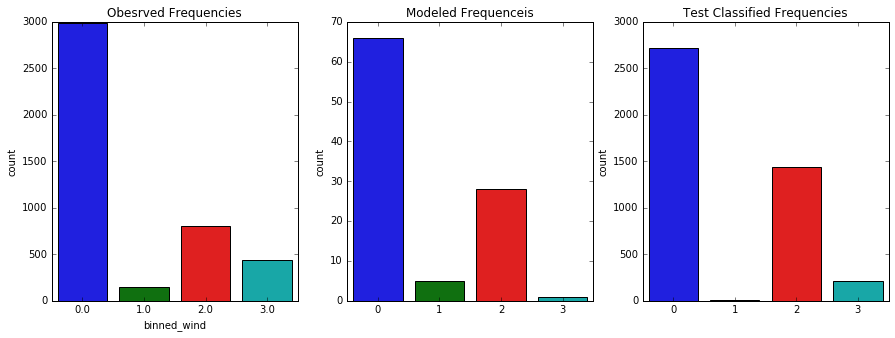

In [28]:
fig, axes = plt.subplots(ncols=3, nrows=1, figsize=(15, 5))
sb.countplot(train.binned_wind, ax=axes[0])
sb.countplot(sseq, ax=axes[1])
sb.countplot(seqs, ax=axes[2])
axes[0].set_title("Obesrved Frequencies")
axes[1].set_title("Modeled Frequenceis")
axes[2].set_title("Test Classified Frequencies")

In [29]:
score = sum(seqs == test.binned_wind)/len(seqs)
print("You've gotten a prediction accuracy of: {}".format(score))

You've gotten a prediction accuracy of: 0.6812785388127854


## Attempts at Improving Accuracy 
We're trying z normalizing

In [13]:
subset_songshan_z = subset_songshan.loc[:, subset_songshan.columns != "binned_wind"].apply(normalize_cols, axis=0)
subset_songshan_z["binned_wind"] = subset_songshan.binned_wind

## Normalization Experimentation
Z normalization was applied to the dataset to see if accuracy improved.   It did not. 

In [14]:
# get splits
train, test = split_train_test(subset_songshan_z, 0.5)

# compute model parameters
tran_mat = compute_wind_trans(train.binned_wind)
wind_means = compute_state_means(train, "binned_wind")
wind_cov = compute_covar(train, "binned_wind")

# create model
model = hmm.GaussianHMM(n_components = tran_mat.shape[0], covariance_type="diag")
model.startprob_ = np.ones(tran_mat.shape[0]) / tran_mat.shape[0]
model.transmat_ = tran_mat
model.means_ = wind_means
model.covars_ = wind_cov

# evaluate on test data and score
logprob, seqs = model.decode(test.loc[:,test.columns != "binned_wind"])
score = sum(seqs == test.binned_wind)/len(seqs)
print("You've gotten a prediction accuracy of: {}".format(score))

You've gotten a prediction accuracy of: 0.6812785388127854


C:\Users\Chris\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:75: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


## Confusion Matrix

In order to evaluate accuracy of model prediction we generated confusion matrices.

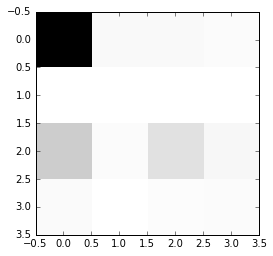

In [15]:
conf = confussion_matrx(test.binned_wind, seqs)
conf.shape
plt.imshow(conf, cmap="Greys", interpolation="nearest")

# Extending Modeling to All Stations
A function was created to extend the modeling to all stations and generate resulting confusion matrices 

In [16]:
def fit_and_test_markov_model(taipai, station, sample_list, train_p = 0.5, full=False, tide=False, fit=False):
    """
    Create a markov model and test its predictions; produces score and confusion matrix
    """
    df_station = taipai.loc[taipai.station == station]
    subset_station = df_station[sample_list]

    # get splits
    train, test = split_train_test(subset_station, train_p)

    # compute model parameters
    tran_mat = compute_wind_trans(train.binned_wind)
    wind_means = compute_state_means(train, "binned_wind")
    
    if full:
        wind_cov = compute_covar_full(train, "binned_wind")
        cov_type = "full"
    
    elif tide:
        wind_cov = tide_covar(train, "binned_wind") 
        cov_type = "tied"
    
    else:
        wind_cov = compute_covar(train, "binned_wind")
        cov_type = "diag"
    
    print(cov_type)
    print(wind_cov)
    
    # create model
    model = hmm.GaussianHMM(n_components = tran_mat.shape[0], covariance_type=cov_type, params="c")
    model.startprob_ = np.ones(tran_mat.shape[0]) / tran_mat.shape[0]
    model.transmat_ = tran_mat
    model.means_ = wind_means
    model.covars_ = wind_cov
    if fit:
        model.fit(train.loc[:, train.columns != "binned_wind"].values)

    # evaluate on test data and score
    logprob, seqs = model.decode(test.loc[:,test.columns != "binned_wind"])
    score = sum(seqs == test.binned_wind)/len(seqs)
    conf_matrix = confussion_matrx(test.binned_wind, seqs)
    return score, conf_matrix

In [17]:
%%capture
stations = []
scores = []
conf_matrices = []
problem = []
for s in taipai.station.unique():
    if len(taipai.loc[taipai.station == s].binned_wind.unique()) < wind_bins:
        problem.append(s)
        continue
        
    try:
        score, conf = fit_and_test_markov_model(taipai, s, sample_list)
        scores.append(score)
        conf_matrices.append(conf)
        stations.append(s)

    except ValueError as e:
        problem.append(s)
        

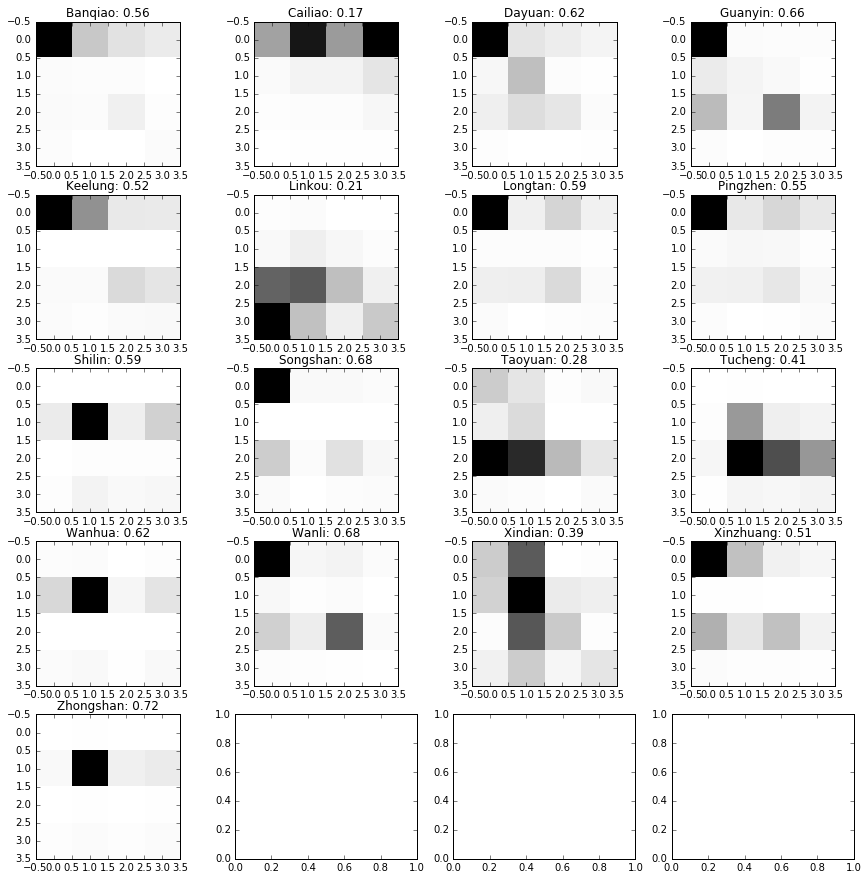

In [18]:
fig, axes = plt.subplots(ncols=4, nrows=5, figsize=(15, 15))

i = 0
for row in axes:
    for ax in row:
        try:
            ax.imshow(conf_matrices[i], cmap="Greys", interpolation="nearest")
            ax.set_title("{}: {}".format(stations[i], round(scores[i], 2)))b
        except IndexError:
            x = "Dummy"
        i += 1

## Covariance Adjustment
As mentioned, we've been using a markov model with gaussian emissions. Up until now, we've assumed that the covariance matrices of our emissions were diagonalized. In other words, within a state the variables had zero covariance.

However, it is easy to imagine this is not the case. We decided to then train models with full covariance matrices.

### Tied Covariance
First we'll look at tied covariance. This is the case where each state has the same full covariance matrix

In [19]:
%%capture
stations = []
scores = []
conf_matrices = []
problem = []
for s in taipai.station.unique():
    if len(taipai.loc[taipai.station == s].binned_wind.unique()) < wind_bins:
        problem.append(s)
        continue
        
    try:
        score, conf = fit_and_test_markov_model(taipai, s, sample_list, tide=True)
        scores.append(score)
        conf_matrices.append(conf)
        stations.append(s)

    except ValueError as e:
        problem.append(s)
        

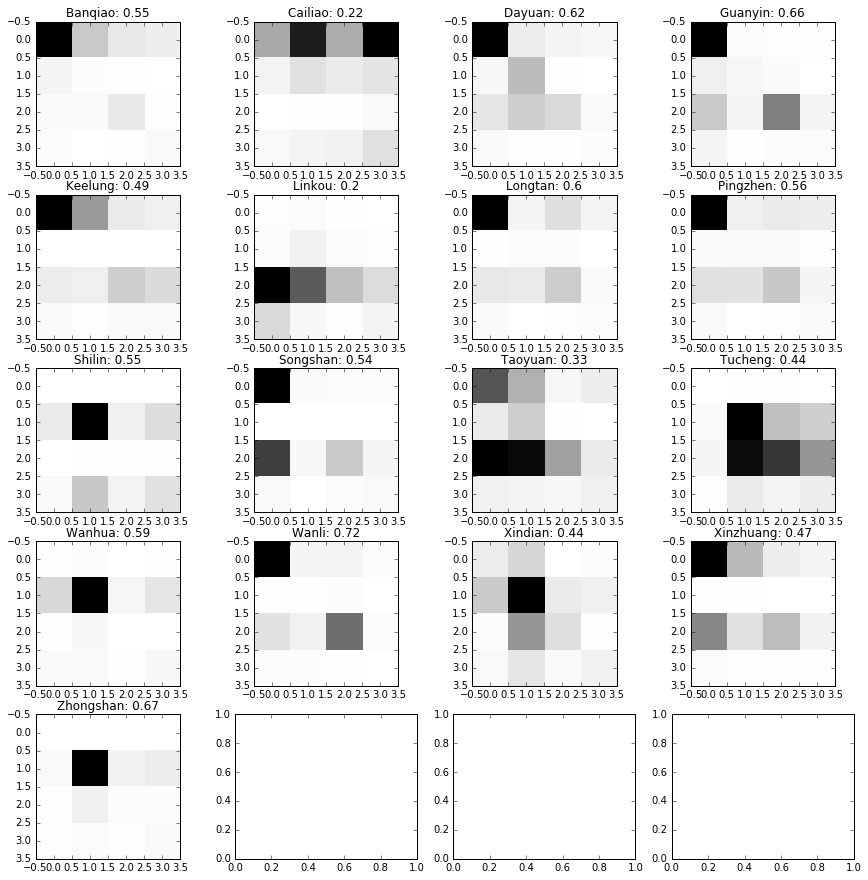

In [20]:
fig, axes = plt.subplots(ncols=4, nrows=5, figsize=(15, 15))

i = 0
                         
for row in axes:
    for ax in row:
        try:
            ax.imshow(conf_matrices[i], cmap="Greys", interpolation="nearest")
            ax.set_title("{}: {}".format(stations[i], round(scores[i], 2)))
        except IndexError:
            x = "Dummy"
        i += 1

### Full Covariance
Next we tested full covariance, where each state had its own full covariance matrix

In [21]:
%%capture
stations = []
scores = []
conf_matrices = []
problem = []
for s in taipai.station.unique():
    if len(taipai.loc[taipai.station == s].binned_wind.unique()) < wind_bins:
        problem.append(s)
        continue
        
    try:
        score, conf = fit_and_test_markov_model(taipai, s, sample_list, full=True)
        scores.append(score)
        conf_matrices.append(conf)
        stations.append(s)

    except ValueError as e:
        problem.append(s)
        

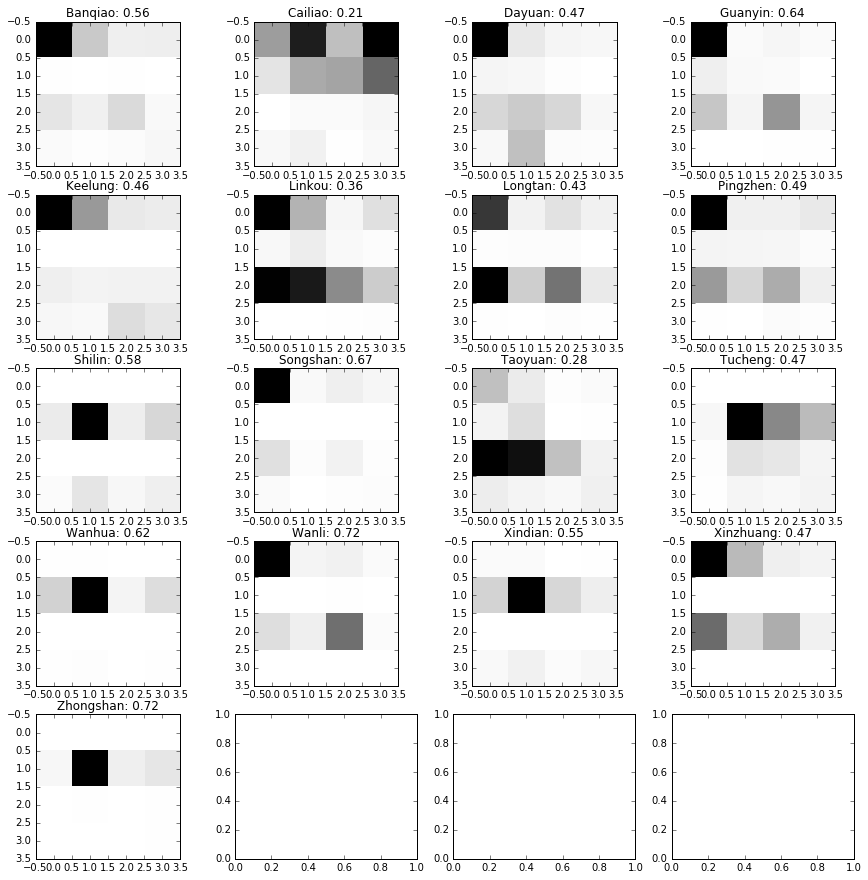

In [22]:
fig, axes = plt.subplots(ncols=4, nrows=5, figsize=(15, 15))

i = 0
                         
for row in axes:
    for ax in row:
        try:
            ax.imshow(conf_matrices[i], cmap="Greys", interpolation="nearest")
            ax.set_title("{}: {}".format(stations[i], round(scores[i], 2)))
        except IndexError:
            x = "Dummy"
        i += 1

# Conclusions

After implimentation of Markov Modeling, our accuracy is almost always higher than random.  The confusion matrices tend to favor the most popular class and ignore and miss classify less frequent classes.  In future implementations, we will rotate wind direction bins to match cardnal direction.  Adding additional wind bins did not improve general accuracy.  Other directions of implimentation could join geographical information to the position of the stations.  Range from Highways, power plants, or other polution generating entities could be used to better relate sources to our sensors. Wind speed and wind direction could be used as differing states.  





#\#getrekt